In [7]:
#initial imports 
import io
import zipfile
import os

In [8]:
  #conection to gdrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from google.colab import drive
  drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [9]:
#connecting to our cats&dogs zip file in drive 
local_zip = '/content/gdrive/My Drive/Colab Notebooks/cats_and_dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp') #creating tmp folder to store our dataset
zip_ref.close()

In [10]:
#creating base directory and linking to our tmp folder
base_dir = '/tmp/cats_and_dogs'

In [12]:
#linking train and validation paths to seperate variables 
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
#Linking cat&dog folders in our train folder
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
#Linking cat&dog folders in our validation folder
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [13]:
#printing few cat&dog images to check if our execution is right
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )
print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.313.jpg', 'cat.1818.jpg', 'cat.890.jpg', 'cat.553.jpg', 'cat.1857.jpg', 'cat.1015.jpg', 'cat.346.jpg', 'cat.930.jpg', 'cat.1960.jpg', 'cat.1740.jpg']
['dog.10978.jpg', 'dog.11726.jpg', 'dog.10712.jpg', 'dog.11546.jpg', 'dog.11307.jpg', 'dog.10525.jpg', 'dog.12031.jpg', 'dog.11124.jpg', 'dog.10753.jpg', 'dog.11516.jpg']


In [14]:
#printing total number of images in each folder
print('total training cat images :', len(os.listdir( train_cats_dir ) ))
print('total training dog images :', len(os.listdir( train_dogs_dir ) ))
print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 2000
total training dog images : 2000
total validation cat images : 500
total validation dog images : 501


In [15]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
pic_index = 0 # Index for iterating over images

In [16]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index+=8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index]
                ]
next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[ pic_index-8:pic_index]
                ]

<Figure size 1152x1152 with 0 Axes>

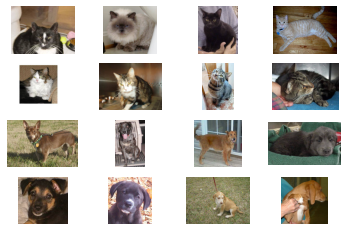

In [17]:
for i, img_path in enumerate(next_cat_pix+next_dog_pix):
 # Set up subplot; subplot indices start at 1
 sp = plt.subplot(nrows, ncols, i + 1)
 sp.axis('Off') # Don't show axes (or gridlines)
 img = mpimg.imread(img_path)
 plt.imshow(img)
plt.show()

In [18]:
import tensorflow as tf
model = tf.keras.models.Sequential([
 # Note the input shape is the desired size of the image 150x150 with 3 bytes color
 tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
 tf.keras.layers.MaxPooling2D(2,2),
 tf.keras.layers.Dropout(0.1),
 tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
 tf.keras.layers.MaxPooling2D(2,2),
 tf.keras.layers.Dropout(0.2),
 tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
 tf.keras.layers.MaxPooling2D(2,2),
 tf.keras.layers.Dropout(0.2),
 tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
 tf.keras.layers.MaxPooling2D(2,2),
 tf.keras.layers.Dropout(0.2),
 tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
 tf.keras.layers.MaxPooling2D(2,2),
 tf.keras.layers.Dropout(0.5),
 # Flatten the results to feed into a DNN
 tf.keras.layers.Flatten(),
 # 512, 256, 128 neuron hidden layer
 tf.keras.layers.Dense(512, activation='relu'),
 tf.keras.layers.Dense(256, activation='relu'),
 tf.keras.layers.Dense(128, activation='relu'),
 # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
 tf.keras.layers.Dense(1, activation='sigmoid')
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 32)        0

In [22]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001),
 loss='binary_crossentropy',
 metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [24]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
 batch_size=20,
 class_mode='binary',
target_size=(150, 150))

Found 4000 images belonging to 2 classes.


In [25]:
# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir,
 batch_size=20,
 class_mode = 'binary',
 target_size = (150, 150))

Found 1021 images belonging to 3 classes.


In [27]:
history = model.fit_generator(train_generator,validation_data=validation_generator,steps_per_epoch=100,
 epochs=20,
 validation_steps=50,
 verbose=2)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


100/100 - 61s - loss: 0.4741 - acc: 0.7685 - val_loss: 0.5468 - val_acc: 0.7410 - 61s/epoch - 610ms/step
Epoch 2/20
100/100 - 59s - loss: 0.4749 - acc: 0.7830 - val_loss: 0.7467 - val_acc: 0.6310 - 59s/epoch - 589ms/step
Epoch 3/20
100/100 - 59s - loss: 0.4509 - acc: 0.7950 - val_loss: 0.5029 - val_acc: 0.7570 - 59s/epoch - 589ms/step
Epoch 4/20
100/100 - 60s - loss: 0.4548 - acc: 0.7995 - val_loss: 0.6362 - val_acc: 0.6690 - 60s/epoch - 602ms/step
Epoch 5/20
100/100 - 61s - loss: 0.4534 - acc: 0.7945 - val_loss: 0.5034 - val_acc: 0.7560 - 61s/epoch - 612ms/step
Epoch 6/20
100/100 - 61s - loss: 0.4465 - acc: 0.7945 - val_loss: 0.7359 - val_acc: 0.6960 - 61s/epoch - 609ms/step
Epoch 7/20
100/100 - 60s - loss: 0.4464 - acc: 0.7945 - val_loss: 0.4960 - val_acc: 0.7730 - 60s/epoch - 602ms/step
Epoch 8/20
100/100 - 60s - loss: 0.4230 - acc: 0.7915 - val_loss: 0.6117 - val_acc: 0.7660 - 60s/epoch - 602ms/step
Epoch 9/20
100/100 - 60s - loss: 0.4204 - acc: 0.8115 - val_loss: 0.4804 - val_acc:

In [28]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
uploaded=files.upload()
for fn in uploaded.keys():
 # predicting images by feeding images from our test folder
 path='/content/' + fn
 img=image.load_img(path, target_size=(150, 150))

 x=image.img_to_array(img)
 x=np.expand_dims(x, axis=0)
 images = np.vstack([x])

 classes = model.predict(images, batch_size=10)

 print(classes[0])

 if classes[0]>0:
   print(fn + " is a dog")

 else:
   print(fn + " is a cat")

Saving 1.jpg to 1.jpg
Saving 2.jpg to 2.jpg
Saving 3.jpg to 3.jpg
Saving 4.jpg to 4.jpg
Saving 5.jpg to 5.jpg
Saving 6.jpg to 6.jpg
Saving 7.jpg to 7.jpg
Saving 8.jpg to 8.jpg
Saving 9.jpg to 9.jpg
Saving 10.jpg to 10.jpg
Saving 11.jpg to 11.jpg
Saving 12.jpg to 12.jpg
Saving 13.jpg to 13.jpg
Saving 14.jpg to 14.jpg
Saving 15.jpg to 15.jpg
Saving 16.jpg to 16.jpg
Saving 17.jpg to 17.jpg
Saving 18.jpg to 18.jpg
Saving 19.jpg to 19.jpg
Saving 20.jpg to 20.jpg
[1.]
1.jpg is a dog
[1.]
2.jpg is a dog
[1.]
3.jpg is a dog
[1.]
4.jpg is a dog
[0.]
5.jpg is a cat
[0.]
6.jpg is a cat
[0.]
7.jpg is a cat
[1.]
8.jpg is a dog
[0.]
9.jpg is a cat
[0.]
10.jpg is a cat
[0.]
11.jpg is a cat
[1.]
12.jpg is a dog
[0.]
13.jpg is a cat
[1.]
14.jpg is a dog
[5.5800066e-20]
15.jpg is a dog
[0.]
16.jpg is a cat
[1.]
17.jpg is a dog
[1.]
18.jpg is a dog
[1.]
19.jpg is a dog
[1.]
20.jpg is a dog


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


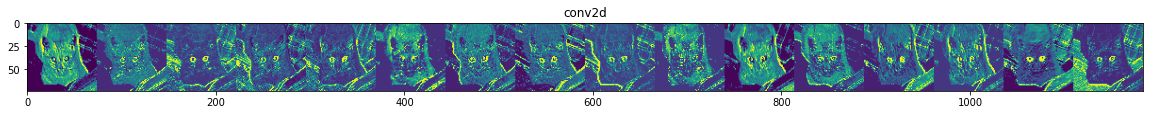

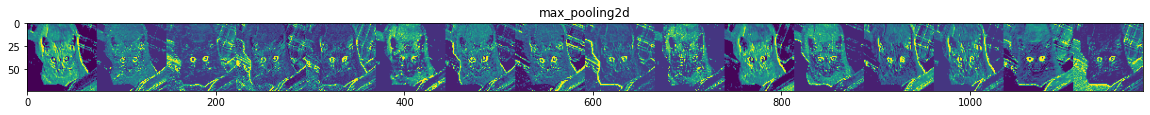

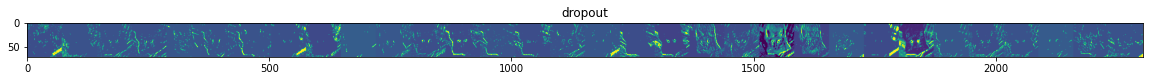

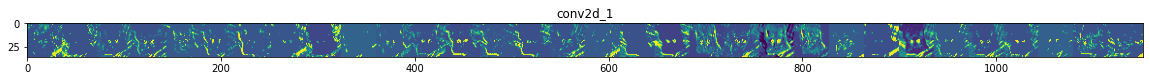

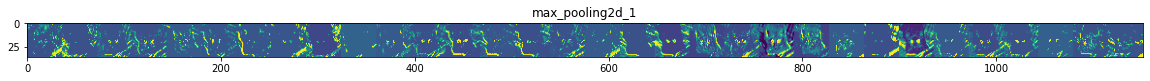

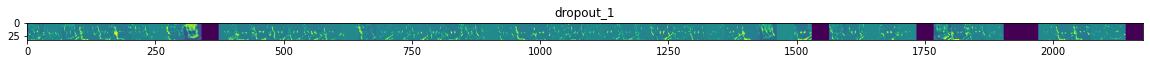

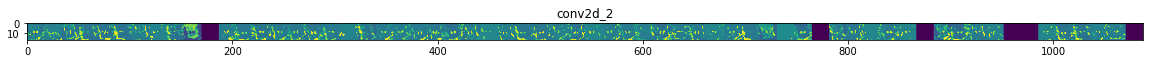

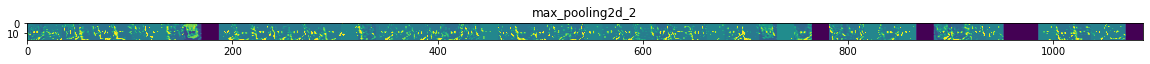

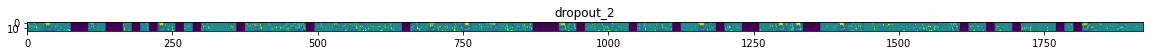

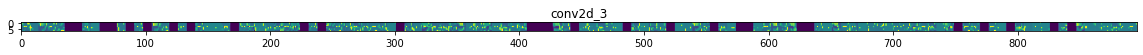

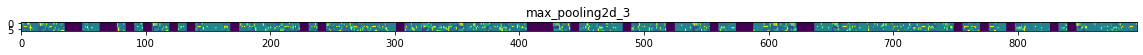

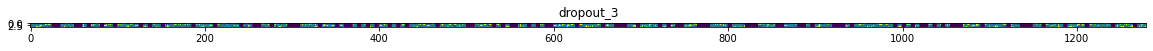

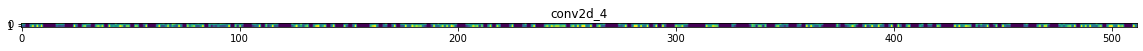

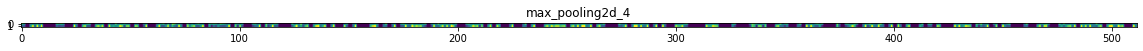

In [29]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
# Defining a new Model that will take an image as input and produce output intermediate representations for all layers in previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150)) # this is a PIL image
x = img_to_array(img) # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape) # Numpy array with shape (1, 150, 150, 3)
# Rescale by 1/255
x /= 255.0
# Running image through our network and obtaining all intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)
# Names of the layers to have them as part of our plot
layer_names = [layer.name for layer in model.layers]
# Displaying our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):

  if len(feature_map.shape) == 4:

 # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1] # number of features in the feature map
    size = feature_map.shape[ 1] # feature map shape (1, size, size, n_features)

 # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
 # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x = feature_map[0,:,:, i]
      x -= x.mean()
      x /= x.std ()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid
 # Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

In [30]:
# Retrieving a list of list results on training and test data sets for each training epoch
acc = history.history[ 'acc' ]
val_acc = history.history[ 'val_acc' ]
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(acc)) # Get number of epochs

<Figure size 432x288 with 0 Axes>

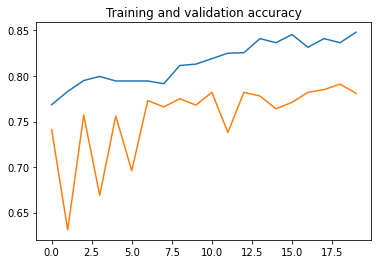

<Figure size 432x288 with 0 Axes>

In [31]:
# Plotting training and validation accuracy per epoch
plt.plot ( epochs, acc )
plt.plot ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()


Text(0.5, 1.0, 'Training and validation loss')

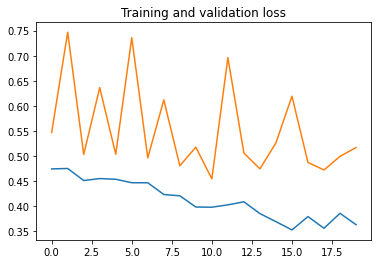

In [32]:
# Plotting training and validation loss per epoch
plt.plot ( epochs, loss )
plt.plot ( epochs, val_loss )
plt.title ('Training and validation loss' )